# Lab 1

## Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)
!wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
path_do_data = './data.txt'

File ‘data.txt’ already there; not retrieving.



The `data.txt` is a tsv file, each line of which contains a sentence in english and a corresponding translation, separated by `\t`. We'll load it into memory and create a list of pairs, which would yield the same interface as with the torchtext's datasets.

In [2]:
with open("data.txt") as f:
    data = [l.rstrip().split("\t") for l in f]

print(f"Dataset size {len(data):,}")
print("Sample:")
data[:5]

Dataset size 50,000
Sample:


[['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.',
  'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.'],
 ['At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.',
  'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.'],
 ['Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.',
  'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.'],
 ['Each has a TV and a private bathroom with shower.',
  'В вашем распоряжении также телевизор и собственная ванная комната с душем.'],
 ['Your room comes with air conditioning and satellite TV.',
  'Номер оснащен кондиционером и спутниковым телевидением.']]

## Data preprocessing

First of all, let's split our dataset into train, test and validation.

In [3]:
import torch
from torch.utils.data import random_split


data_size = len(data)
train_size = int(0.8 * data_size)
test_size = int(0.15 * data_size)
val_size = data_size - train_size - test_size
train_data, test_data, val_data = random_split(
    data, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42)
)
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Val size: {len(val_data)}")

Train size: 40000
Test size: 7500
Val size: 2500


Here comes the preprocessing. If you find pieces, that you don't understand, please, go back to 3rd week's practice notebook. The code is mostly taken from it.

Do not hesitate to use BPE or more complex preprocessing pipeline ;)

In [4]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

def tokenize(sent):
    return tokenizer.tokenize(sent.lower())

In [5]:
from collections import Counter
from torchtext.vocab import vocab as Vocab

src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=3)
trg_vocab = Vocab(trg_counter, min_freq=3)

In [6]:
unk_token = "<unk>"
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token]

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

print(f"Source (en) vocabulary size: {len(src_vocab)}")
print(f"Target (ru) vocabulary size: {len(trg_vocab)}")

Source (en) vocabulary size: 6711
Target (ru) vocabulary size: 9310


In [7]:
def encode(sent, vocab):
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]

In [8]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        src_encoded = encode(src, src_vocab)
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])
    return src_padded, trg_padded


batch_size = 256
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate_batch)

src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([41, 256]), torch.Size([45, 256]))

## Model side

In [ ]:
import random

import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        _, hidden = self.rnn(embedded)
        return hidden


class Decoder(nn.Module):
    def __init__(self, n_tokens, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_tokens = n_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(n_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, n_tokens)

    def forward(self, input, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        output, hidden = self.rnn(embedded, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.hid_dim == decoder.hid_dim, "encoder and decoder must have same hidden dim"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "encoder and decoder must have equal number of layers"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        hidden = self.encoder(src)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
enc = Encoder(len(src_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)
dec = Decoder(len(trg_vocab), emb_dim=256, hid_dim=512, n_layers=2, dropout=0.5)
model = Seq2Seq(enc, dec).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model.apply(init_weights);

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 16,233,822 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])
loss_history, train_loss_history, val_loss_history = [], [], []

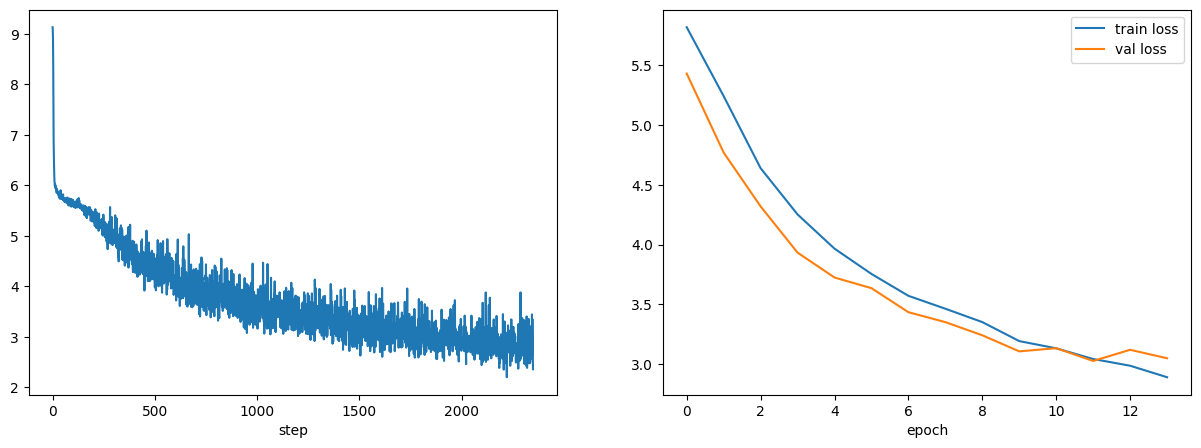

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_


# Please don't use tensorboard here.
# It doesn't save the training plots in the notebook.
n_epochs = 15
clip = 1
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for src, trg in train_dataloader:
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg)

        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:
            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(val_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in val_dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)

            output = output.view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)

## Model evaluation

In [ ]:
trg_itos = trg_vocab.get_itos()
model.eval()
max_len = 50
with torch.no_grad():
    for i, (src, trg) in enumerate(val_data):
        encoded = encode(src, src_vocab)[::-1]
        encoded = torch.tensor(encoded)[:, None].to(device)
        hidden = model.encoder(encoded)

        pred_tokens = [trg_vocab[sos_token]]
        for _ in range(max_len):
            decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
            pred, hidden = model.decoder(decoder_input, hidden)
            _, pred_token = pred.max(dim=1)
            if pred_token == trg_vocab[eos_token]:
                # Don't add it to prediction for cleaner output.
                break

            pred_tokens.append(pred_token.item())

        print(f"src: '{src.rstrip().lower()}'")
        print(f"trg: '{trg.rstrip().lower()}'")
        print(f"pred: '{' '.join(trg_itos[i] for i in pred_tokens[1:])}'")
        print()

        if i == 10:
            break

src: 'all apartments have a dvd player and satellite tv, a kitchen with a microwave, and a washing machine and a tumble dryer.'
trg: 'все они оснащены телевизором со спутниковыми каналами и dvd-плеером, а также располагают кухней с микроволновой печью и стиральной/сушильной машиной.'
pred: 'в числе удобств стиральная машина , стиральная машина , микроволновая печь , холодильник , телевизор с плоским экраном и кабельными каналами .'

src: 'they are fitted with blackout curtains, free drinking water and free toiletries.'
trg: 'гостям предоставляется бесплатная питьевая вода и бесплатные туалетно-косметическими принадлежности.'
pred: 'в распоряжении гостей собственная ванная комната с бесплатными туалетно - косметическими принадлежностями .'

src: 'a small refrigerator, coffee-making facilities and a work desk are included.'
trg: 'к услугам гостей также небольшой холодильник, принадлежности для кофе и рабочий стол.'
pred: 'в числе удобств — , , , , и принадлежности для чая / кофе .'

src:

The metric often used in NMT is the BLEU. We'll also use it to evaluate our models. In fact, the goal of this homework is to beat the specified baseline BLEU scores.

Here is how you can calculate the score for your model:

In [ ]:
from nltk.translate.bleu_score import corpus_bleu


references, hypotheses = [], []
with torch.no_grad():
    for src, trg in test_dataloader:
        output = model(src.to(device), trg.to(device), teacher_forcing_ratio=0)
        output = output.cpu().numpy().argmax(axis=2)

        for i in range(trg.shape[1]):
            reference = trg[:, i]
            reference_tokens = [trg_itos[id_] for id_ in reference]
            reference_tokens = [tok for tok in reference_tokens if tok not in specials]
            references.append(reference_tokens)

            hypothesis = output[:, i]
            hypothesis_tokens = [trg_itos[id_] for id_ in hypothesis]
            hypothesis_tokens = [tok for tok in hypothesis_tokens if tok not in specials]
            hypotheses.append(hypothesis_tokens)

# corpus_bleu works with multiple references
bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

Your model shows test BLEU of 16.6


Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

In [ ]:
!pip install transformers 
!pip install sentencepiece==0.1.94

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.5/507.5 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentencepiece: filename=sentencepiece-0.1.94-cp310-cp310-linux_x86_64.whl size=1439363 sha256=c0a92e7bf7235b3fc02e11f73aeb1ab1c9810b6a7e7ed6ddbbede21fd896b41e
  Stored in directory: /root/.cache/pip/wheels/09/a1/54/a3196ca6f241737de6ae3dcdf00a80383f9dd5e5f7dc78a97e
Successfully built sentencepiece


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd

with open('data.txt', 'r') as file:
    data = file.read().split('\n')

en = []
ru = []

for line in data:
    segments = line.split('\t')
    if len(segments) == 2: 
        en.append(segments[0])
        ru.append(segments[1])
    else:
        print(f'Skipping line: {line}')

df = pd.DataFrame(list(zip(en, ru)), columns=['en', 'ru'])
df.to_csv('data.csv', index=False)

Skipping line: 


In [ ]:
print(df)

                                                      en  \
0      Cordelia Hotel is situated in Tbilisi, a 3-min...   
1      At Tupirmarka Lodge you will find a 24-hour fr...   
2      Featuring free WiFi in all areas, Naigao Xiaow...   
3      Each has a TV and a private bathroom with shower.   
4      Your room comes with air conditioning and sate...   
...                                                  ...   
49995  The spacious air-conditioned rooms open out to...   
49996  Minsk Ring road is a 5-minute drive from the p...   
49997         There is a private bathroom with a shower.   
49998  It is a 15-minute drive from Malacca Town Cent...   
49999  Each room at Apartments na Podgornoy is colour...   

                                                      ru  
0      Отель Cordelia расположен в Тбилиси, в 3 минут...  
1      В числе удобств лоджа Tupirmarka круглосуточна...  
2      Апартаменты Naigao Xiaowo расположены в городе...  
3      В вашем распоряжении также телевизор

In [ ]:
import datasets
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from random import randrange

russian_dataset = load_dataset("csv", data_files="data.csv")

russian_dataset = russian_dataset["train"].map(lambda ex, i: {"id": i, "translation": dict(ex)}, remove_columns=["en", "ru"], features=datasets.Features({"id": datasets.Value("string"), "translation": datasets
.Translation(languages=["en", "ru"])}), with_indices=True,)
russian_dataset = russian_dataset.train_test_split(test_size=0.2)
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
source_lang = "en"
target_lang = "ru"
prefix = "translate English to Russian: "

def preprocess_function(examples):
    inputs = []
    targets = []
    for example in examples["translation"]:
        if example[source_lang] is not None and example[target_lang] is not None and \
        len(example[source_lang].strip()) > 3 and len(example[target_lang].strip()) > 3:
            inputs.append(prefix + example[source_lang].strip())
            targets.append(example[target_lang].strip())
        else:
            "There is an issue with this segment:"
            print("Source:", example[source_lang])
            print("Target:", example[target_lang])
            random_num = randrange(10000)
            print("Replaced with", random_num)
            inputs.append(prefix + str(random_num))
            targets.append(str(random_num))
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)
        model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print(russian_dataset.map)
tokenized_russian = russian_dataset.map(preprocess_function, batched=True)
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1eec8d9b0c9e9257/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


<bound method DatasetDict.map of DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 10000
    })
})>


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Source: .
Target: .
Replaced with 9796


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.29.2
Uninstalling transformers-4.29.2:
  Successfully uninstalled transformers-4.29.2
Found existing installation: accelerate 0.19.0
Uninstalling accelerate-0.19.0:
  Successfully uninstalled accelerate-0.19.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
  Using cached accelerate-0.19.0-py3-none-any.whl (219 kB)


In [ ]:
training_args = Seq2SeqTrainingArguments(
    evaluation_strategy = "epoch",
    logging_strategy = "no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    output_dir="./"
)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install -q sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
import numpy as np
from datasets import load_dataset, load_metric

metric = load_metric("sacrebleu")


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

<ipython-input-21-14f8af507ce0>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


In [ ]:
train_testvalid = tokenized_russian['train'].train_test_split(test_size=0.2)

dataset = datasets.DatasetDict({
    'train': train_testvalid['train'],
    'valid': train_testvalid['test'],
    'test': tokenized_russian['test']})

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 32000
    })
    valid: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
})

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,No log,0.747641,34.797000,28.004800
2,No log,0.710294,35.816300,27.902900


TrainOutput(global_step=8000, training_loss=0.842112060546875, metrics={'train_runtime': 2364.658, 'train_samples_per_second': 27.065, 'train_steps_per_second': 3.383, 'total_flos': 746217419046912.0, 'train_loss': 0.842112060546875, 'epoch': 2.0})

In [ ]:
test_part = tokenized_russian['test'].train_test_split(test_size=0.2)

from transformers import pipeline
from tqdm.autonotebook import tqdm
import pandas as pd
tqdm.pandas()

device = "cuda:0"
translator = pipeline("translation_en_to_ru", model=model, tokenizer=tokenizer, device=0)

def translate(text):
    return translator(text)[0]['translation_text']

df = pd.DataFrame(test_part['test'])
df['preds'] = df['translation'].apply(lambda x: translate(x['en']))


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
print(df['preds'][0])
i = 0
df["target"] = " "
for i in range(len(df['translation'])):
  df['target'][i] = df['translation'][i]['ru']
  i += 1

print(df['translation'][0]['ru'])


Кроме того, гости могут отдохнуть в шампанском-баре Le Moét и заказать широкий выбор коктейлей, изысканных блюд для пальца, яркого кофе с эклером или сезонных устриц и трюфелей.
В баре Le Moët Champagne можно отдохнуть и заказать различные коктейли, изысканные закуски, кофе Illy с эклерами или сезонные устрицы и трюфели.


In [ ]:
df


,id,translation,input_ids,attention_mask,labels,preds,target
0,5417,{'en': 'Guests can also relax at the Le Moët C...,"[18412, 3462, 9, 2179, 38, 55575, 23, 127, 123...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[49, 6863, 30, 990, 171, 821, 573, 35495, 45, ...","Кроме того, гости могут отдохнуть в шампанском...",В баре Le Moët Champagne можно отдохнуть и зак...
1,29123,{'en': 'The hotel is only a 5-minute walk to t...,"[18412, 3462, 9, 2179, 38, 32, 12402, 34, 322,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1110, 2390, 19488, 732, 6, 239, 3732, 1004, 6...",Отель находится всего в 5 минутах ходьбы от це...,Отель расположен всего в 5 минутах ходьбы от ц...
2,36370,{'en': 'The bus stop offering access to Tbilis...,"[18412, 3462, 9, 2179, 38, 32, 11307, 2491, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1110, 2390, 1215, 8029, 902, 7877, 5792, 3525...","Автобусная остановка, откуда можно добраться д...",Отель Night House находится в 5 минутах ходьбы...
3,2216,{'en': 'You can also look forward to an attrac...,"[18412, 3462, 9, 2179, 38, 103, 127, 123, 1080...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[49, 608, 95, 260, 1304, 15412, 258, 16, 41, 1...",Вы также можете полюбоваться на красивую сауну.,В числе удобств — сауна.
4,5586,"{'en': 'Apartments also have a kitchen.', 'ru'...","[18412, 3462, 9, 2179, 38, 24420, 18039, 123, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[49, 72, 5628, 1010, 21571, 44, 78, 497, 42, 6...",В апартаментах есть кухня.,В апартаментах также есть кухня.
...,...,...,...,...,...,...,...
1995,20637,{'en': 'The nearest airport is Pulkovo Airport...,"[18412, 3462, 9, 2179, 38, 32, 29880, 14071, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3925, 5774, 1648, 130, 28693, 985, 3948, 1792...",Расстояние до аэропорта Пулково составляет 17 км.,Расстояние до аэропорта Пулково составляет 17 км.
1996,20092,{'en': 'The apartments all have a private entr...,"[18412, 3462, 9, 2179, 38, 32, 45368, 80, 63, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[840, 72, 5628, 1010, 6814, 100, 17712, 11657,...",Во всех апартаментах есть собственный вход с д...,Все апартаменты располагают отдельным входом с...
1997,13639,{'en': 'Academie Internationale de la Gastrono...,"[18412, 3462, 9, 2179, 38, 86, 4095, 31470, 24...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[49, 1654, 2801, 3832, 30, 16, 10594, 4256, 84...",Победительница ресторана и террасы Safran Acad...,"В ресторане с террасой Safran, который был удо..."
1998,44537,{'en': 'Tea Room Keyaki restaurant offers a he...,"[18412, 3462, 9, 2179, 38, 12360, 68, 3235, 15...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[49, 27319, 1591, 171, 200, 68, 7247, 40, 3099...",В ресторане Chay Room Keaki подают сервированн...,В кафе Keyaki для гостей сервируют сытный завт...


In [ ]:
decoded_preds, decoded_labels = postprocess_text(df['preds'], df['target'])

result = metric.compute(predictions=decoded_preds, references=decoded_labels)
result = {"bleu score": result["score"]}
print(result)

{'bleu score': 36.02308588141115}
